# Figure 5

This code can be used to reproduce Figure 5.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

from dtw_gi import dtw_gi_barycenter_averaging, softdtw_gi_barycenter
from utils import plot_trajectory, set_fig_style, make_spirals, make_folia


def has_3d(dataset):
    for sample in dataset:
        if sample.shape[-1] == 3:
            return True
    return False


set_fig_style()

np.random.seed(0)
torch.manual_seed(0)

# Parameters of the experiment
n_spirals = 5
n_spirals_shown = 5
sz = 60
sz_barycenter = 30
d_barycenter = 2

# Datasets
list_dataset_generators = [
    lambda n, sz: make_spirals(n, sz=sz, shift=False, some_3d=False),
    lambda n, sz: make_folia(n, sz=sz, shift=False, some_3d=False),
    lambda n, sz: make_spirals(n, sz=sz, noise=.01, shift=False, some_3d=True)
]

# Methods
list_barycenter_fun = [
    lambda dataset, sz, b: dtw_barycenter_averaging(dataset,
                                                    init_barycenter=b,
                                                    barycenter_size=sz,
                                                    max_iter=200),
    lambda dataset, sz, b: softdtw_barycenter(dataset,
                                              gamma=.01,
                                              init=b,
                                              max_iter=200),
    lambda dataset, sz, b: dtw_gi_barycenter_averaging(dataset,
                                                       init_barycenter=b,
                                                       barycenter_size=sz,
                                                       verbose=False,
                                                       n_init=3,
                                                       max_iter=1000,
                                                       keep_p_matrices=True,
                                                       metric_params={
                                                           "max_iter": 1000
                                                       })[0],
    lambda dataset, sz, _: softdtw_gi_barycenter(dataset,
                                                 gamma=.01,
                                                 normalize_dist=True,
                                                 barycenter_size=sz,
                                                 barycenter_dim=d_barycenter,
                                                 stiefel_opt=True,
                                                 verbose=False,
                                                 n_init=3,
                                                 max_iter=10 * 1000,
                                                 step_verbose=500,
                                                 lr=.001)[0]
]
list_method_names = ["DTW", "softDTW", "DTW-GI", "softDTW-GI"]

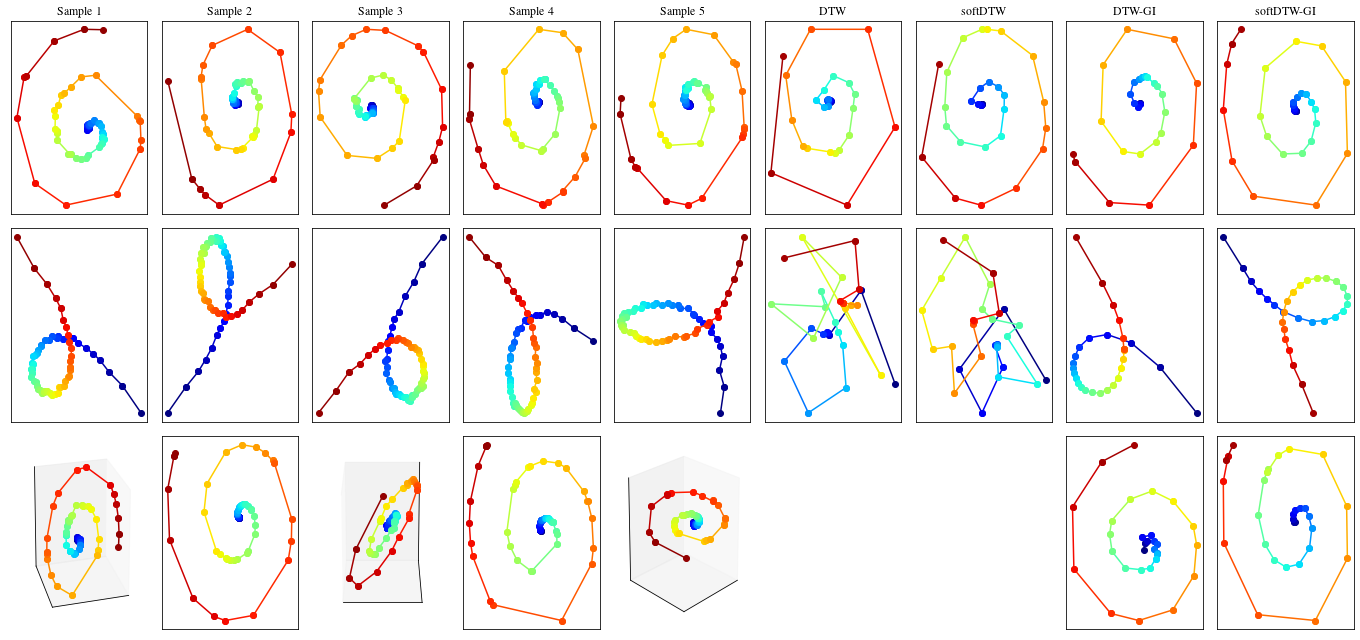

In [2]:
angles_visu = [75, np.nan, -90, np.nan, 45]

fig = plt.figure(figsize=(3 * n_spirals_shown + len(list_barycenter_fun),
                    3 * len(list_dataset_generators)))
for idx_dataset, dataset_fun in enumerate(list_dataset_generators):
    spirals = dataset_fun(n_spirals, sz)

    # Plot sample spirals
    for i in range(n_spirals_shown):
        if spirals[i].shape[-1] == 3:
            ax = fig.add_subplot(len(list_dataset_generators),
                                 n_spirals_shown + len(list_barycenter_fun),
                                 (n_spirals_shown + len(list_barycenter_fun))
                                 * idx_dataset + i + 1, projection="3d")
            plot_trajectory(spirals[i], ax=ax, plot_3d=True)
            ax.set_zticks([])
            ax.view_init(elev=20., azim=angles_visu[i])
        else:
            ax = fig.add_subplot(len(list_dataset_generators),
                                 n_spirals_shown + len(list_barycenter_fun),
                                 (n_spirals_shown + len(list_barycenter_fun))
                                 * idx_dataset + i + 1)
            plot_trajectory(spirals[i], ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        if idx_dataset == 0:
            ax.set_title("Sample {}".format(i + 1))

    # Plot barycenters
    for i, (barycenter_fun, title) in enumerate(zip(list_barycenter_fun,
                                                    list_method_names)):
        init_b = np.random.randn(sz_barycenter, d_barycenter)
        if title in ["DTW", "softDTW"] and has_3d(spirals):
            continue
        barycenter = barycenter_fun(spirals, sz_barycenter, init_b)
        ax = plt.subplot(len(list_dataset_generators),
                         n_spirals_shown + len(list_barycenter_fun),
                         (n_spirals_shown + len(list_barycenter_fun))
                         * idx_dataset +
                         n_spirals_shown + i + 1)
        plot_trajectory(barycenter, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        if idx_dataset == 0:
            ax.set_title(title)

plt.tight_layout()
plt.show()